In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [2]:
pca_df = pd.read_pickle("../../../../data/test_correlation/PCA/PCA.pkl")
output_path = "/home/imonge/Documents/Abiotic/PCA"

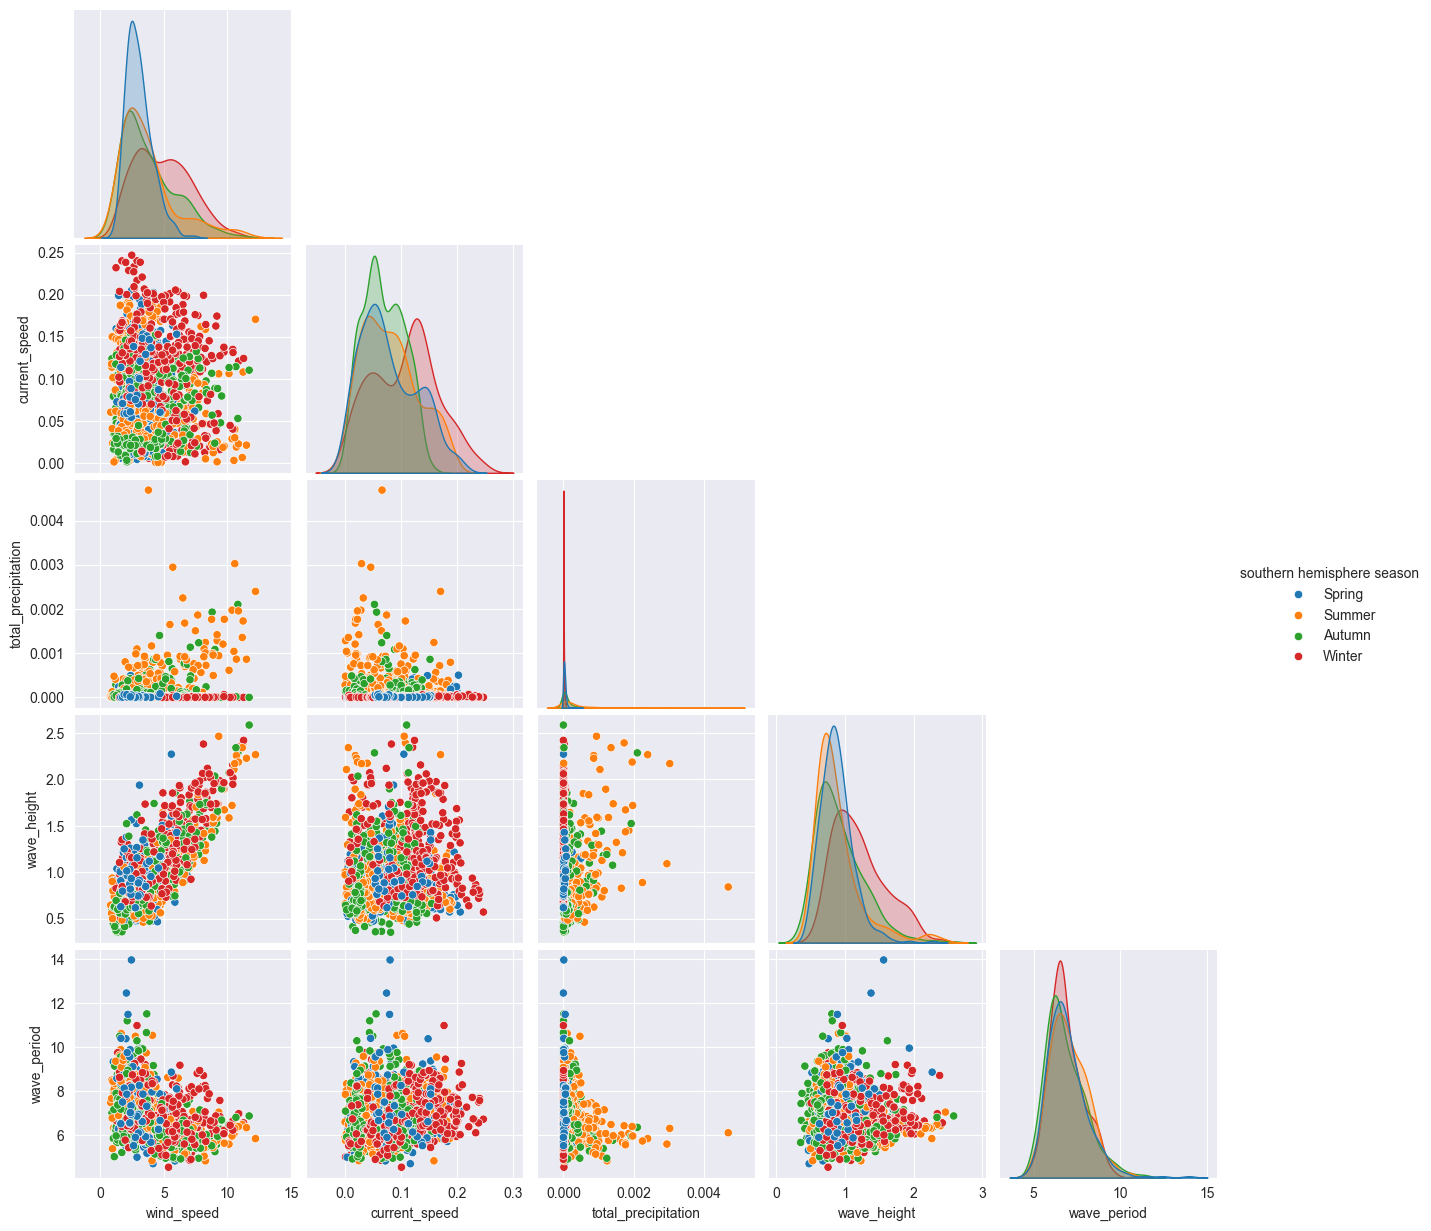

In [3]:
# Ajouter un target de saison
def southern_hemisphere_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Summer"
    elif month in [3, 4, 5]:
        return "Autumn"
    elif month in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

pca_df["southern hemisphere season"] = pca_df.index.map(southern_hemisphere_season)

sns.pairplot(pca_df, hue="southern hemisphere season", corner=True)

# # Save figure
# output_pairplot = f"{output_path}/PCA_pairplot.png"
# plt.savefig(output_pairplot)
plt.show()

In [4]:
# Standardisation
X = pca_df.drop(columns=["southern hemisphere season"])
y = pca_df["southern hemisphere season"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

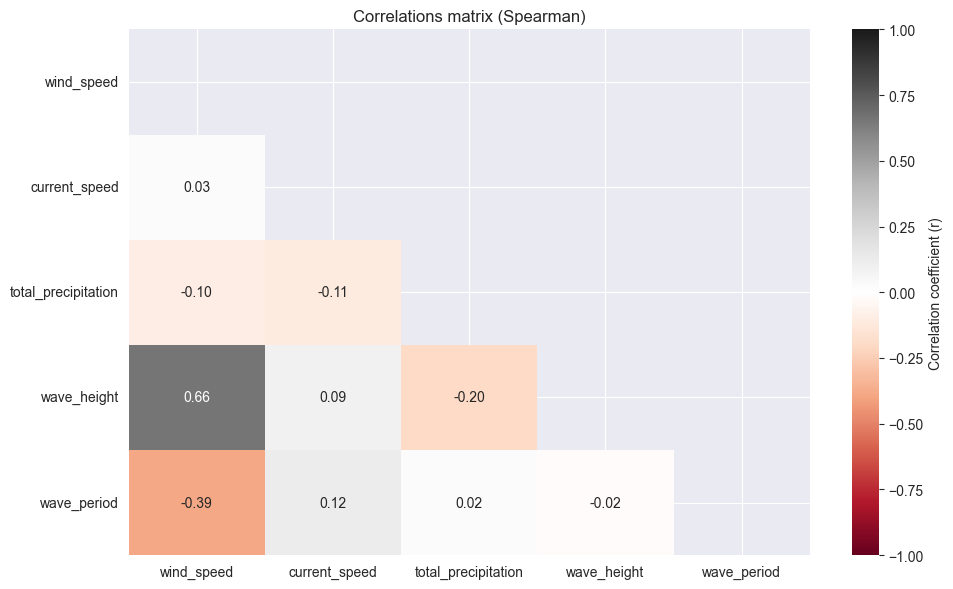

In [16]:
# Correlations matrix (Spearman)
corr_matrix =  X.corr(method='spearman')

# Plot matrix with significant correlations
plt.figure(figsize=(10,6))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Keeps half of the matrix

sns.heatmap(
            corr_matrix,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap="RdGy",
            vmin=-1, vmax=1,
            cbar_kws={"label":"Correlation coefficient (r)"}
)

plt.title("Correlations matrix (Spearman)")
plt.tight_layout()

# Save figure
output_corr_matrix = f"{output_path}/spear_corr_matrix.png"
plt.savefig(output_corr_matrix)
#plt.show()

In [6]:
# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

Cumulative explained variance: [0.39512077 0.63030721 0.80755246 0.97159014 1.        ]


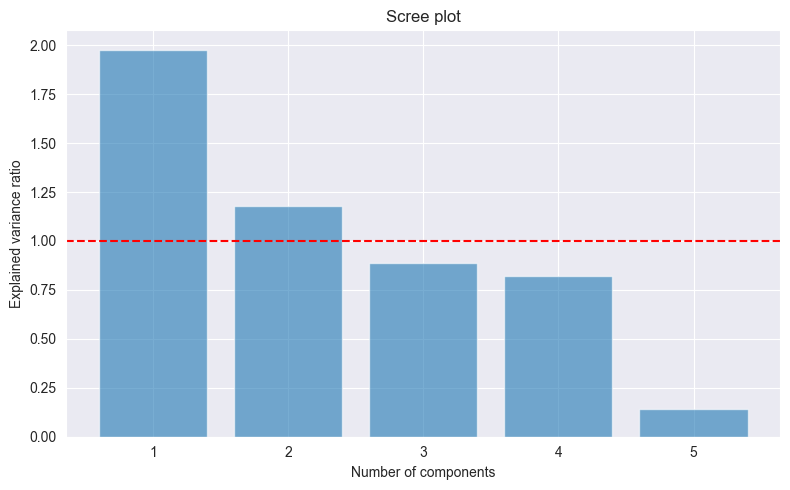

In [8]:
# Scree plot
eigenvalues = pca.explained_variance_

print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))


plt.figure(figsize=(8,5))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.6)
plt.axhline(y=1.0, color='red', linestyle='--', label="kaiser criterion")


plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot")
plt.grid(True)
plt.tight_layout()

# # Save figure
# output_scree_plot = f"{output_path}/scree_plot.png"
# plt.savefig(output_scree_plot)
plt.show()

In [9]:
# Contribution and representation quality
components = pca.components_ # eigenvectors
explained = pca.explained_variance_ratio_ * 100

contrib = pd.DataFrame(
    components**2,
    columns=X.columns,
    index = [f"PC{i+1}" for i in range(len(components))]
).T * 100

print("\n--- Contribution des variables (%) ---")
print(contrib.round(2))


--- Contribution des variables (%) ---
                       PC1    PC2    PC3    PC4    PC5
wind_speed           45.37   0.85   0.39   2.12  51.27
current_speed         0.03  47.03  18.54  34.40   0.01
total_precipitation  10.68  13.28  18.73  56.83   0.48
wave_height          35.05  13.55   4.18   6.49  40.72
wave_period           8.87  25.29  58.16   0.16   7.52


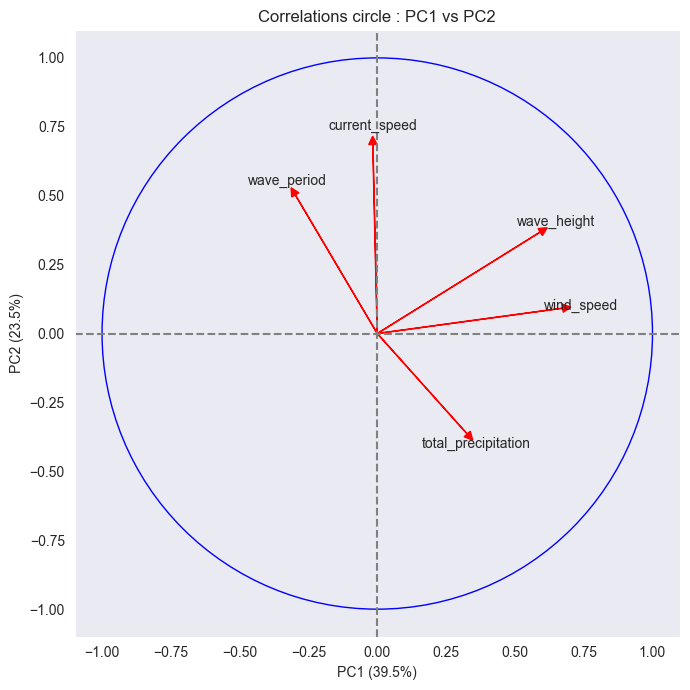

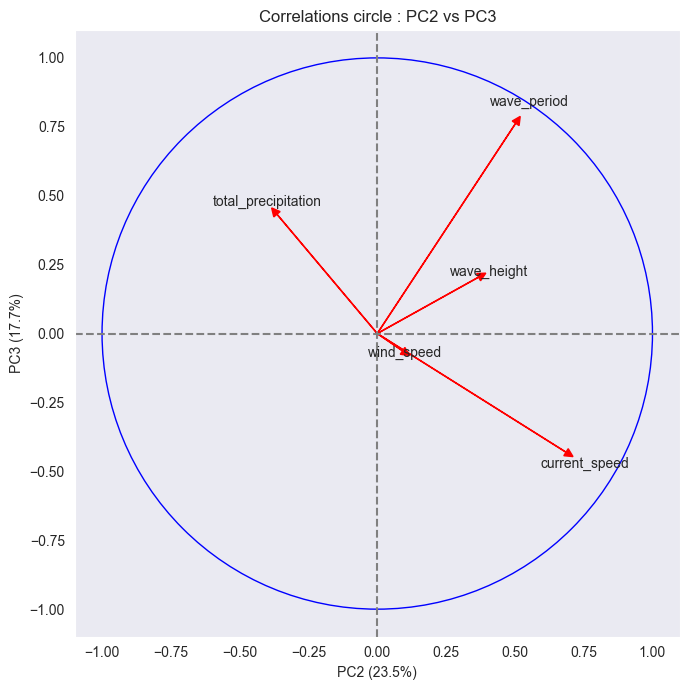

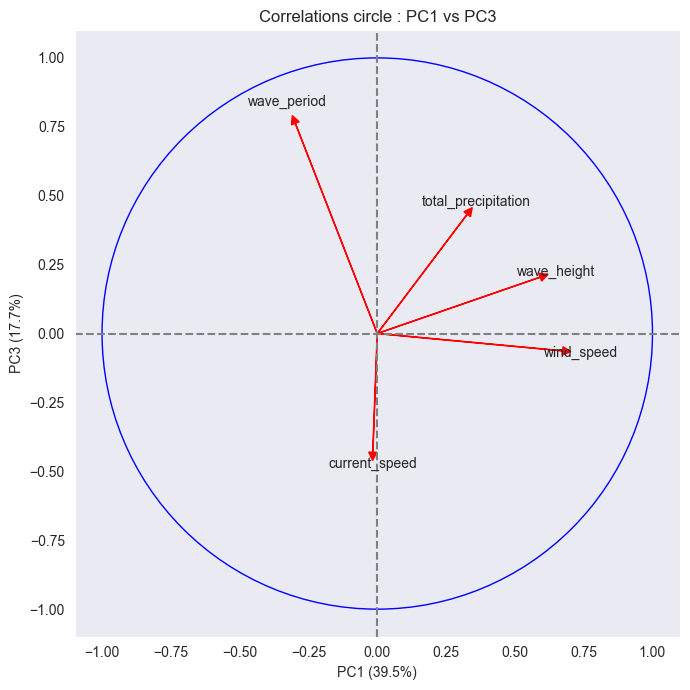

In [10]:
# Correlation circle
def plot_correlation_circle(pca, features, pc1=1, pc2=2):
    pcs = pca.components_
    explained = pca.explained_variance_ratio_ * 100

    fig, ax = plt.subplots(figsize=(7,7))
    for i, (x, y) in enumerate(zip(pcs[pc1 - 1], pcs[pc2 - 1])):
        ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, fc='red', ec='red')
        ax.text(x*1.1, y * 1.1, features[i], ha='center', va='center')

    # Circle
    circle = plt.Circle((0, 0), 1, color='b', fill=False)
    ax.add_patch(circle)

    # Axes
    ax.axhline(0, linestyle='--', color='grey')
    ax.axvline(0, linestyle='--', color='grey')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

    # Dynamic labels
    ax.set_xlabel(f"PC{pc1} ({explained[pc1-1]:.1f}%)")
    ax.set_ylabel(f"PC{pc2} ({explained[pc2-1]:.1f}%)")
    ax.set_title(f"Correlations circle : PC{pc1} vs PC{pc2}")

    plt.grid()
    plt.tight_layout()
    plt.show()

# # Save figure
    # if output_path:
    #     filename = f"{output_path}/cocircle_PC{pc1}_PC{pc2}.png"
    #     plt.savefig(filename)
    # plt.close()

plot_correlation_circle(pca, X.columns, pc1=1, pc2=2)
plot_correlation_circle(pca, X.columns, pc1=2, pc2=3)
plot_correlation_circle(pca, X.columns, pc1=1, pc2=3)

